**Requirments for this notebook**
* An environment that allows Perl-compatible grepping, in some cases you may replace `-P` with `-E`.
* A Python environment with `numpy` and `matplotlib` installed.

## Toy Example

In [1]:
!cat sacct.log | grep toy

toy_example_gpu
23471690     toy_example+         8G                00:06:10    05:53.557     00:03:05 2025-10-05T12:34:16  COMPLETED    0:0 
toy_example
23471691     toy_example+         8G                00:30:36    30:18.561     00:15:18 2025-10-05T12:46:51    TIMEOUT    0:0 


In [2]:
!cat toy_example.out | grep "Time to complete" 

Time to complete epoch 000 (training only): 19.12 seconds
Time to complete epoch 001 (training only): 18.94 seconds
Time to complete epoch 002 (training only): 18.53 seconds
Time to complete epoch 003 (training only): 18.51 seconds
Time to complete epoch 004 (training only): 18.44 seconds
Time to complete epoch 005 (training only): 18.62 seconds
Time to complete epoch 006 (training only): 18.67 seconds


In [3]:
!cat toy_example.out | grep "Time to complete" > toy_cpu_times.out

In [4]:
import re
pat = r'\d\d.\d\d'
with open('toy_cpu_times.out', 'r') as f:
    data = [float(re.search(pat, ln).group()) for ln in f]
sum(data) / len(data)

18.69

In [5]:
!cat toy_example_gpu.out | grep "Time to complete" 

Time to complete epoch 000 (training only): 3.05 seconds
Time to complete epoch 001 (training only): 2.26 seconds
Time to complete epoch 002 (training only): 2.36 seconds
Time to complete epoch 003 (training only): 2.48 seconds
Time to complete epoch 004 (training only): 2.32 seconds
Time to complete epoch 005 (training only): 2.34 seconds
Time to complete epoch 006 (training only): 2.44 seconds
Time to complete epoch 007 (training only): 2.47 seconds
Time to complete epoch 008 (training only): 2.42 seconds
Time to complete epoch 009 (training only): 2.49 seconds


In [6]:
!cat toy_example_gpu.out | grep "Time to complete"  > toy_gpu_times.out

In [7]:
import re
pat = r'\d.\d\d'
with open('toy_gpu_times.out', 'r') as f:
    data = [float(re.search(pat, ln).group()) for ln in f]
sum(data) / len(data)

2.463

## Assignment 1

Clean up messy `.out` file

In [8]:
!wc -l out_assignment1.out

1181 out_assignment1.out


In [9]:
!tr '\r' '\n' < out_assignment1.out > cleaned.out
!wc -l cleaned.out

39833 cleaned.out


In [10]:
!cat cleaned.out | grep -P 'Time to complete'

Time to complete epoch 000 (training only): 9801.51 seconds
Time to complete epoch 001 (training only): 9746.52 seconds
Time to complete epoch 002 (training only): 9674.71 seconds
Time to complete epoch 003 (training only): 9634.26 seconds
Time to complete epoch 004 (training only): 9560.82 seconds
Time to complete epoch 005 (training only): 9567.43 seconds
Time to complete epoch 006 (training only): 9575.03 seconds


* Training time was about 18.75 hours
* Total time was 22.15 hours
* So translation time was about 3.4 hours
* Cross-check this with a only-translation run on the same input text.

In [11]:
!cat cleaned.out | grep -P "Epoch \d\d\d: (loss|valid_loss)" > summary.out
!cat cleaned.out | grep -P "Epoch \d\d\d: (loss|valid_loss)"

Epoch 000: loss 1.954 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 17.96 | clip 0.9405
Epoch 000: valid_loss 2.44 | num_tokens 18 | batch_size 5e+03 | valid_perplexity 11.4 | BLEU 8.077
Epoch 001: loss 1.577 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 13.74 | clip 0.8956
Epoch 001: valid_loss 2.09 | num_tokens 18 | batch_size 5e+03 | valid_perplexity 8.08 | BLEU 12.309
Epoch 002: loss 1.471 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 13.09 | clip 0.8621
Epoch 002: valid_loss 1.98 | num_tokens 18 | batch_size 5e+03 | valid_perplexity 7.28 | BLEU 11.760
Epoch 003: loss 1.413 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 13.59 | clip 0.8589
Epoch 003: valid_loss 1.9 | num_tokens 18 | batch_size 5e+03 | valid_perplexity 6.69 | BLEU 14.199
Epoch 004: loss 1.375 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 14.62 | clip 0.8682
Epoch 004: valid_loss 1.83 | num_tokens 18 | batch_size 5e+03 | valid_perplexity 6.25 | BLEU 16.6

In [12]:
with open("summary.out", "r") as f:
    data = [ln for ln in f]

In [13]:
data[0]

'Epoch 000: loss 1.954 | lr 0.0003 | num_tokens 18.48 | batch_size 64 | grad_norm 17.96 | clip 0.9405\n'

Parse data into memory

In [14]:
import re
loss_pat = r" loss (\d+\.\d+)"
valid_loss_pat = r"valid_loss (\d+\.\d+)"
BLEU_pat = r"BLEU (\d+\.\d+)"
valid_perp_pat = r"valid_perplexity (\d+\.\d+)"

train_data = []
valid_data = []

for ln in data:
    if re.search(loss_pat, ln):
        epoch = {}
        epoch["loss"] = float(re.search(loss_pat, ln).group(1))
        train_data.append(epoch)
    elif re.search(valid_loss_pat, ln):
        epoch = {}
        epoch["valid_loss"] = float(re.search(valid_loss_pat, ln).group(1))
        epoch['BLEU'] = float(re.search(BLEU_pat, ln).group(1))
        epoch['valid_perplexity'] = float(re.search(valid_perp_pat, ln).group(1))
        valid_data.append(epoch)
        


In [15]:
train_data, valid_data

([{'loss': 1.954},
  {'loss': 1.577},
  {'loss': 1.471},
  {'loss': 1.413},
  {'loss': 1.375},
  {'loss': 1.349},
  {'loss': 1.329}],
 [{'valid_loss': 2.44, 'BLEU': 8.077, 'valid_perplexity': 11.4},
  {'valid_loss': 2.09, 'BLEU': 12.309, 'valid_perplexity': 8.08},
  {'valid_loss': 1.98, 'BLEU': 11.76, 'valid_perplexity': 7.28},
  {'valid_loss': 1.9, 'BLEU': 14.199, 'valid_perplexity': 6.69},
  {'valid_loss': 1.83, 'BLEU': 16.631, 'valid_perplexity': 6.25},
  {'valid_loss': 1.78, 'BLEU': 17.378, 'valid_perplexity': 5.96},
  {'valid_loss': 1.76, 'BLEU': 19.658, 'valid_perplexity': 5.82}])

Plot

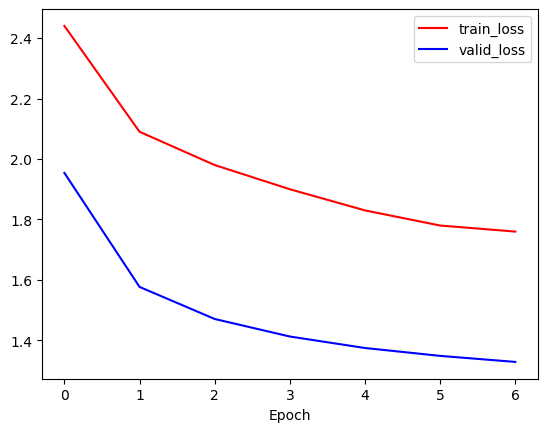

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(valid_data)), [d['valid_loss'] for d in valid_data], color='red')
plt.plot(np.arange(len(train_data)), [d['loss'] for d in train_data], color='blue')
plt.legend(['train_loss', 'valid_loss'])
plt.xlabel('Epoch')
plt.show()

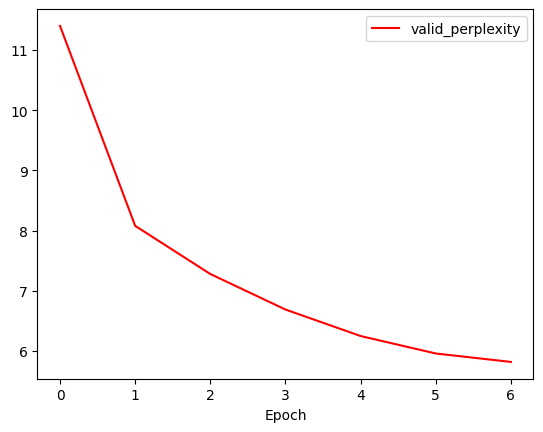

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(valid_data)), [d['valid_perplexity'] for d in valid_data], color='red')
plt.legend(['valid_perplexity'])
plt.xlabel('Epoch')
plt.show()

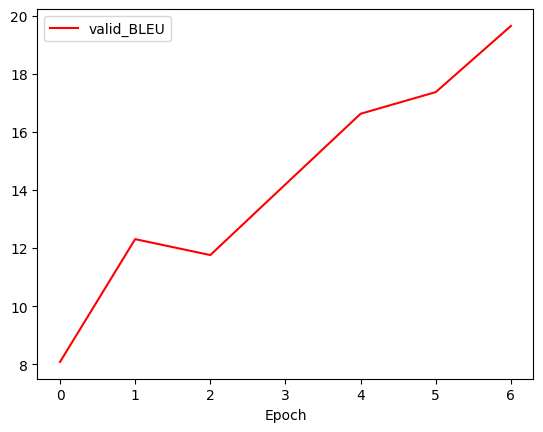

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(valid_data)), [d['BLEU'] for d in valid_data], color='red')
plt.legend(['valid_BLEU'])
plt.xlabel('Epoch')
plt.show()

In [21]:
!cat out_assignment1.out | grep -P "(Final Test Set|BLEU score:)" 

Final Test Set Results: BLEU 16.21
BLEU score: 1.25


In [28]:
!cat out_assignment1.out | tail -n 6

[2025-10-06 10:50:38] Wrote 5000 lines to cz-en/output.txt
[2025-10-06 10:50:38] Translation completed in 7379.50 seconds
[2025-10-06 10:50:40] That's 100 lines that end in a tokenized period ('.')
[2025-10-06 10:50:40] It looks like you forgot to detokenize your test data, which may hurt your score.
[2025-10-06 10:50:40] If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
BLEU score: 1.25


In [29]:
!cat cz-en.out


tput: unknown terminal "xterm-16color"
Filesystems usage for user rshanm ( uid 646260053 ):
-------------------------------------------------------------------------------------
Directory                       Used   Limit   Used,%         Files     Limit
-------------------------------------------------------------------------------------
/home/rshanm                   260KB    15GB     0.0%            56    100000
/data/rshanm                    19GB   200GB     9.1%         40836          
/scratch/rshanm                   0B    20TB     0.0%             1          

/shares/atomt.pilot.s3it.uzh   1.4GB    10TB     0.0%            13          
-------------------------------------------------------------------------------------

Files on /scratch may be purged after 30 days.
See https://docs.s3it.uzh.ch/cluster/data

[2025-10-07 09:55:12] COMMAND: translate.py --cuda --input /home/rshanm/shares/atomt.pilot.s3it.uzh/cz-en/data/raw/test.cz --src-tokenizer cz-en/tokenizers/cz-bpe-8000

In [30]:
!cat sk-en.out


tput: unknown terminal "xterm-16color"
Filesystems usage for user rshanm ( uid 646260053 ):
-------------------------------------------------------------------------------------
Directory                       Used   Limit   Used,%         Files     Limit
-------------------------------------------------------------------------------------
/home/rshanm                   243KB    15GB     0.0%            56    100000
/data/rshanm                    19GB   200GB     9.1%         40838          
/scratch/rshanm                   0B    20TB     0.0%             1          

/shares/atomt.pilot.s3it.uzh   1.4GB    10TB     0.0%            13          
-------------------------------------------------------------------------------------

Files on /scratch may be purged after 30 days.
See https://docs.s3it.uzh.ch/cluster/data

[2025-10-07 09:55:33] COMMAND: translate.py --cuda --input ep-sk-en-test/test.sk --src-tokenizer cz-en/tokenizers/cz-bpe-8000.model --tgt-tokenizer cz-en/tokenizers/en